# NLP Assignment: Spell Correction for ASR Noun Enhancement
## Complete Implementation with Model Fine-tuning

**Comprehensive spell correction system for medical ASR transcriptions**
- Focus on medication names and medical terminology
- Baseline vs. Advanced transformer models
- Full evaluation on test set with noun-specific metrics
- Real-time GPU acceleration

## Phase 0: Setup & Installation

In [1]:
# Install all required libraries
!pip install -q pandas numpy openpyxl
!pip install -q nltk spacy scikit-learn
!pip install -q editdistance Levenshtein
!pip install -q transformers torch sentencepiece sacremoses
!pip install -q datasets accelerate
!pip install -q matplotlib seaborn plotly scipy
!python -m spacy download en_core_web_sm

print("All dependencies installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.8 MB/s  0:00:00m0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
All dependencies installed successfully!


In [ ]:
import pandas as pd
import numpy as np
import nltk
import spacy
import re
import torch
import warnings
from collections import Counter, defaultdict
from typing import List, Tuple, Dict

# NLP imports
import editdistance
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.corpus import words as nltk_words
from nltk.util import ngrams
from nltk import FreqDist
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Transformers imports
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import Dataset, DatasetDict

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('maxent_ne_chunker', quiet=True)
nltk.download('words', quiet=True)

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print("\nAll imports loaded successfully!")

## Phase 1: Data Loading & Exploratory Data Analysis (EDA)

In [ ]:
# Load dataset
print("Loading dataset")
file_path = '../Spell_Correction_for_ASR_Noun_Enhancement_assignment_dataset.xlsx'

df = pd.read_excel(file_path)
df.columns = ['correct_sentence', 'asr_sentence']

# Remove any null values
df = df.dropna()
df = df.reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"First row:")
print(f"  Correct: {df.loc[0, 'correct_sentence']}")
print(f"  ASR:     {df.loc[0, 'asr_sentence']}")

Loading dataset...
Dataset shape: (10000, 2)
First row:
  Correct: It is important to follow your doctor's instructions carefully when taking AMLOT-AT.
  ASR:     It is important to follow your doctor's instructions carefully when taking amlodat.


In [4]:
# Comprehensive EDA
print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS (EDA)")
print("="*80)

# Basic statistics
df['correct_length'] = df['correct_sentence'].apply(lambda x: len(str(x).split()))
df['asr_length'] = df['asr_sentence'].apply(lambda x: len(str(x).split()))
df['length_diff'] = abs(df['correct_length'] - df['asr_length'])

print(f"\nDataset Size: {len(df)} pairs")
print(f"Duplicates: {df.duplicated(subset=['correct_sentence', 'asr_sentence']).sum()}")

print(f"\nCorrect Sentence Statistics:")
print(f"  Mean length: {df['correct_length'].mean():.2f} words")
print(f"  Median length: {df['correct_length'].median():.0f} words")
print(f"  Min/Max: {df['correct_length'].min()}/{df['correct_length'].max()} words")

print(f"\nASR Sentence Statistics:")
print(f"  Mean length: {df['asr_length'].mean():.2f} words")
print(f"  Median length: {df['asr_length'].median():.0f} words")
print(f"  Min/Max: {df['asr_length'].min()}/{df['asr_length'].max()} words")

print(f"\nLength Difference Statistics:")
print(f"  Mean difference: {df['length_diff'].mean():.2f} words")
print(f"  Max difference: {df['length_diff'].max()} words")

# Vocabulary analysis
correct_vocab = set()
asr_vocab = set()

for sent in df['correct_sentence']:
    correct_vocab.update(str(sent).lower().split())

for sent in df['asr_sentence']:
    asr_vocab.update(str(sent).lower().split())

print(f"\nVocabulary Analysis:")
print(f"  Correct vocabulary size: {len(correct_vocab)}")
print(f"  ASR vocabulary size: {len(asr_vocab)}")
print(f"  Vocabulary overlap: {len(correct_vocab & asr_vocab)}")
print(f"  Unique to correct: {len(correct_vocab - asr_vocab)}")
print(f"  Unique to ASR: {len(asr_vocab - correct_vocab)}")


EXPLORATORY DATA ANALYSIS (EDA)

Dataset Size: 10000 pairs
Duplicates: 20

Correct Sentence Statistics:
  Mean length: 12.76 words
  Median length: 12 words
  Min/Max: 6/30 words

ASR Sentence Statistics:
  Mean length: 13.04 words
  Median length: 13 words
  Min/Max: 5/30 words

Length Difference Statistics:
  Mean difference: 0.42 words
  Max difference: 9 words

Vocabulary Analysis:
  Correct vocabulary size: 13252
  ASR vocabulary size: 14575
  Vocabulary overlap: 3959
  Unique to correct: 9293
  Unique to ASR: 10616


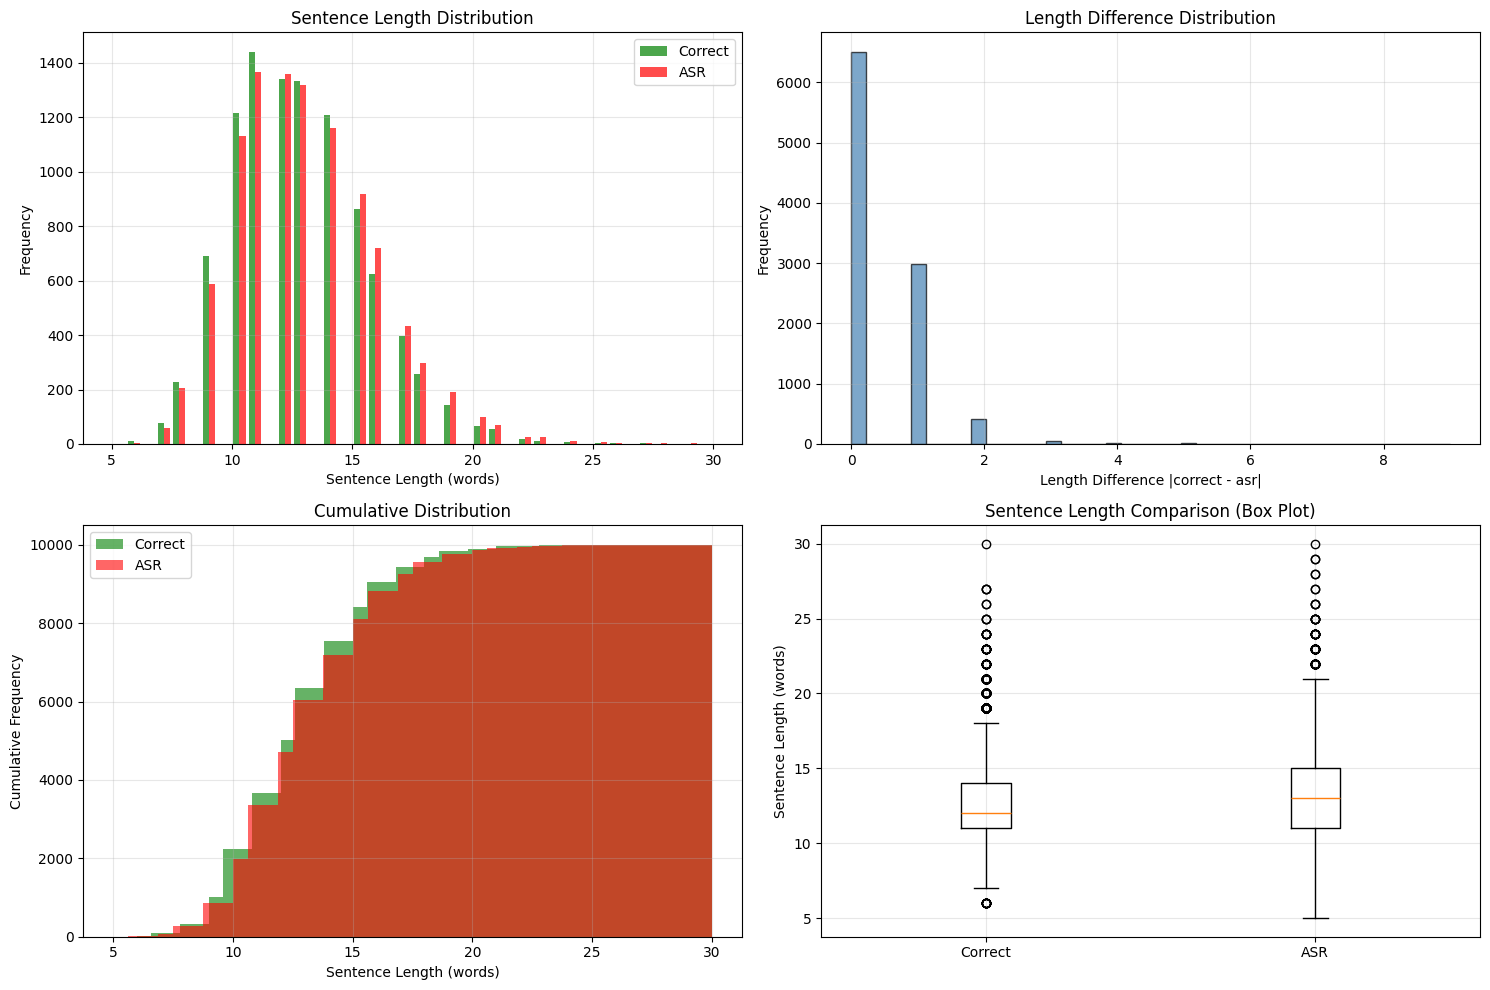


EDA visualizations saved as '01_eda_analysis.png'


In [5]:
# Visualize EDA
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sentence length distribution
axes[0, 0].hist([df['correct_length'], df['asr_length']], bins=40, label=['Correct', 'ASR'], color=['green', 'red'], alpha=0.7)
axes[0, 0].set_xlabel('Sentence Length (words)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Sentence Length Distribution')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Length difference
axes[0, 1].hist(df['length_diff'], bins=40, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Length Difference |correct - asr|')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Length Difference Distribution')
axes[0, 1].grid(alpha=0.3)

# Cumulative distribution
axes[1, 0].hist(df['correct_length'], bins=40, cumulative=True, color='green', alpha=0.6, label='Correct')
axes[1, 0].hist(df['asr_length'], bins=40, cumulative=True, color='red', alpha=0.6, label='ASR')
axes[1, 0].set_xlabel('Sentence Length (words)')
axes[1, 0].set_ylabel('Cumulative Frequency')
axes[1, 0].set_title('Cumulative Distribution')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Box plot
axes[1, 1].boxplot([df['correct_length'], df['asr_length']], labels=['Correct', 'ASR'])
axes[1, 1].set_ylabel('Sentence Length (words)')
axes[1, 1].set_title('Sentence Length Comparison (Box Plot)')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('01_eda_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

print("\nEDA visualizations saved as '01_eda_analysis.png'")


Medical Terminology Coverage:
  Medical terms in correct sentences: 3957
  Medical terms in ASR sentences:     2002
  Missed medical terms (correct but not ASR): 3495

Top 20 Medical Terms (Correct):
[('medication', 2379), ('treat', 1615), ('treating', 807), ('tab', 448), ('medicine', 447), ('treatment', 405), ('patients', 387), ('inflammation', 327), ('respiratory', 292), ('that', 280), ('alleviate', 215), ('combination', 186), ('inflammatory', 88), ('over-the-counter', 79), ("patient's", 74), ('well-being', 73), ('sulfate', 61), ('at', 58), ('administration', 57), ('anti-inflammatory', 55)]


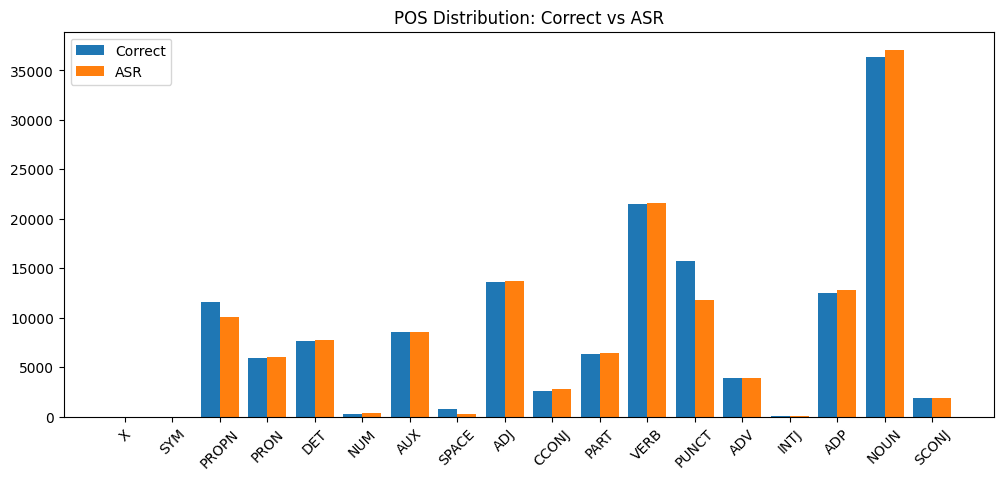


Dataset Structure Analysis Completed Successfully!


In [6]:
def tokenize_simple(text):
    return re.findall(r"[A-Za-z0-9\-']+", text.lower())

def looks_medical(token):
    """
    Detects medical / drug-like terms using:
    - hyphens
    - uppercase letters
    - common drug suffixes
    """
    token = token.strip()
    drug_suffixes = ['-xr', '-sr', '-dr', '-er', 'cine', 'lol', 'pril', 'sartan', 'mab', 'at', 'tab']

    if '-' in token:
        return True
    if any(suffix in token.lower() for suffix in drug_suffixes):
        return True
    if re.search(r"[A-Z]{2,}", token):  # brand names
        return True
    
    return False

df['correct_med_terms'] = df['correct_sentence'].apply(lambda s: [t for t in tokenize_simple(s) if looks_medical(t)])
df['asr_med_terms'] = df['asr_sentence'].apply(lambda s: [t for t in tokenize_simple(s) if looks_medical(t)])

correct_med_vocab = set(t for lst in df['correct_med_terms'] for t in lst)
asr_med_vocab = set(t for lst in df['asr_med_terms'] for t in lst)

print(f"\nMedical Terminology Coverage:")
print(f"  Medical terms in correct sentences: {len(correct_med_vocab)}")
print(f"  Medical terms in ASR sentences:     {len(asr_med_vocab)}")
print(f"  Missed medical terms (correct but not ASR): {len(correct_med_vocab - asr_med_vocab)}")

# Top medical terms
top_med_terms = Counter([t for lst in df['correct_med_terms'] for t in lst]).most_common(20)
print("\nTop 20 Medical Terms (Correct):")
print(top_med_terms)

# POS Tagging Differences
def extract_pos_counts(sentences):
    pos_counts = Counter()
    for s in sentences:
        doc = nlp(s)
        for token in doc:
            pos_counts[token.pos_] += 1
    return pos_counts

correct_pos = extract_pos_counts(df['correct_sentence'])
asr_pos = extract_pos_counts(df['asr_sentence'])

# POS comparison plot
pos_tags = list(set(correct_pos.keys()) | set(asr_pos.keys()))
pos_correct_counts = [correct_pos.get(tag,0) for tag in pos_tags]
pos_asr_counts = [asr_pos.get(tag,0) for tag in pos_tags]

plt.figure(figsize=(12,5))
x = np.arange(len(pos_tags))
plt.bar(x - 0.2, pos_correct_counts, width=0.4, label='Correct')
plt.bar(x + 0.2, pos_asr_counts, width=0.4, label='ASR')
plt.xticks(x, pos_tags, rotation=45)
plt.title("POS Distribution: Correct vs ASR")
plt.legend()
plt.show()

print("\nDataset Structure Analysis Completed Successfully!")

## Phase 2: Error Analysis & Noun Extraction

In [7]:
!pip install jellyfish --quiet


PHASE 2: ERROR WORD EXTRACTION & ANALYSIS

Extracting errors with improved alignment...

Total extracted errors: 16251

Error Type Distribution:
error_type
character_substitution          6187
segmentation_error              3715
character_insertion_deletion    2733
phonetic_substitution           2285
word_level_error                1331
Name: count, dtype: int64

Saved:
  - error_database_full.csv
  - error_medications.csv
  - error_general_nouns.csv


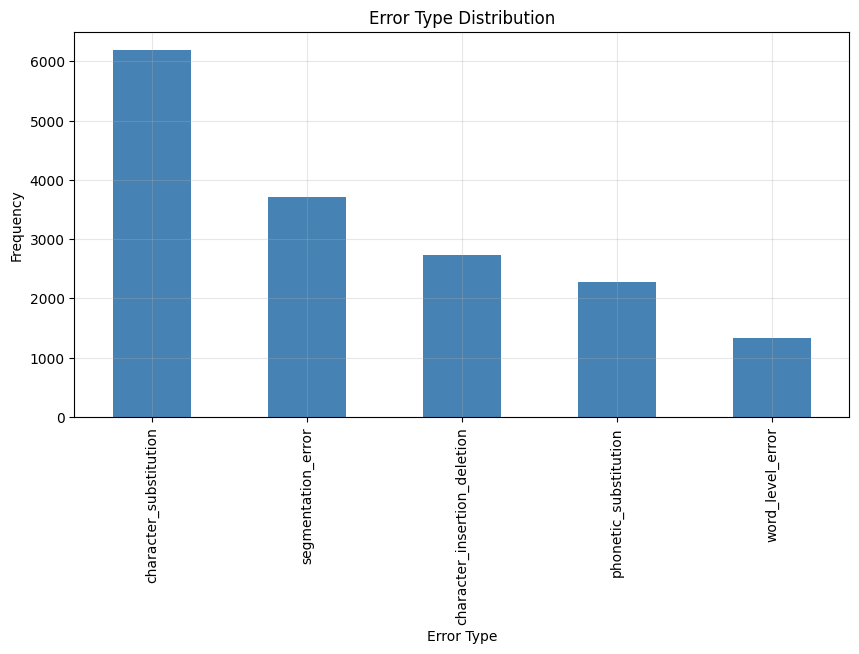


Error analysis completed successfully.


In [ ]:
print("\n" + "="*80)
print("PHASE 2: ERROR WORD EXTRACTION & ANALYSIS")
print("="*80)

from difflib import SequenceMatcher
import jellyfish   # for phonetic similarity


# 1. alignment between correct and ASR tokens
def align_tokens(correct_words, asr_words):
    """
    Align words using SequenceMatcher to detect:
    - substitutions
    - insertions
    - deletions
    - segmentation/boundary issues
    """
    matcher = SequenceMatcher(None, correct_words, asr_words)
    
    aligned = []
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == "equal":
            for c, a in zip(correct_words[i1:i2], asr_words[j1:j2]):
                aligned.append((c, a))
        elif tag == "replace":
            # word-level substitution
            a = correct_words[i1:i2]
            b = asr_words[j1:j2]
            max_len = max(len(a), len(b))
            for k in range(max_len):
                c_word = a[k] if k < len(a) else ""
                a_word = b[k] if k < len(b) else ""
                aligned.append((c_word, a_word))
        elif tag == "delete":
            # ASR missed words
            for c_word in correct_words[i1:i2]:
                aligned.append((c_word, ""))
        elif tag == "insert":
            # ASR added extra words
            for a_word in asr_words[j1:j2]:
                aligned.append(("", a_word))
    
    return aligned


# 2. Error Type Classification
def classify_error_type(correct_word, asr_word):
    if correct_word == asr_word:
        return "no_error"

    edit_dist = editdistance.eval(correct_word, asr_word)
    len_diff = abs(len(correct_word) - len(asr_word))

    # Character-level small edits
    if edit_dist <= 2 and len_diff <= 1:
        return "character_substitution"

    # Insertions / deletions
    if len_diff >= 2 and edit_dist <= 3:
        return "character_insertion_deletion"

    # Phonetic match
    if jellyfish.soundex(correct_word) == jellyfish.soundex(asr_word):
        return "phonetic_substitution"

    # Word boundary / segmentation
    if " " in correct_word or " " in asr_word or len_diff > 3:
        return "segmentation_error"

    # Completely wrong word
    return "word_level_error"


# 3. Medical terminology detection
drug_suffixes = ["ine","ate","one","ol","pril","sartan","mab","nib","vir","azole","mycin","dipine","cillin"]

def is_medical_token(word):
    word = word.lower()
    
    if "-" in word: return True
    if re.search(r"[A-Z]{2,}", word): return True  # brand names
    if any(word.endswith(suffix) for suffix in drug_suffixes): return True
    
    return False


# 4. Extract all errors and categorize
print("\nExtracting errors with improved alignment")
errors_list = []
error_word_db = {
    "medications": [],
    "medical_terms": [],
    "general_nouns": []
}

for idx, row in df.iterrows():
    c_words = tokenize_simple(row['correct_sentence'])
    a_words = tokenize_simple(row['asr_sentence'])

    aligned_pairs = align_tokens(c_words, a_words)

    for correct_word, asr_word in aligned_pairs:
        if correct_word == asr_word:
            continue

        # classify error
        e_type = classify_error_type(correct_word, asr_word)

        # build row
        entry = {
            "correct": correct_word,
            "asr": asr_word,
            "error_type": e_type,
            "edit_distance": editdistance.eval(correct_word, asr_word),
            "sentence_idx": idx
        }
        errors_list.append(entry)

        # Categorize word type
        if correct_word.strip() == "":
            continue  # skip empty placeholders

        if is_medical_token(correct_word):
            error_word_db["medications"].append(entry)
        else:
            # Only run POS tagging if the token is non-empty
            if correct_word and re.search(r"[A-Za-z0-9]", correct_word):
                doc = nlp(correct_word)
                if len(doc) > 0 and doc[0].pos_ in ["NOUN", "PROPN"]:
                    error_word_db["general_nouns"].append(entry)



errors_df = pd.DataFrame(errors_list)

print(f"\nTotal extracted errors: {len(errors_df)}")
print("\nError Type Distribution:")
print(errors_df["error_type"].value_counts())


# 5. Save error databases
errors_df.to_csv("error_database_full.csv", index=False)
pd.DataFrame(error_word_db["medications"]).to_csv("error_medications.csv", index=False)
pd.DataFrame(error_word_db["general_nouns"]).to_csv("error_general_nouns.csv", index=False)

print("\nSaved:")
print("  - error_database_full.csv")
print("  - error_medications.csv")
print("  - error_general_nouns.csv")


# 6. Visualizations (compatible with the block)
plt.figure(figsize=(10,5))
errors_df["error_type"].value_counts().plot(kind="bar", color="steelblue")
plt.title("Error Type Distribution")
plt.xlabel("Error Type")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

print("\nError analysis completed successfully.")


## Phase 3: Data Preprocessing & Data Splitting

In [ ]:
print("\n" + "="*80)
print("PHASE 3: DATA PREPROCESSING & SPLITTING")
print("="*80)

# Text cleaning
def clean_text(text: str) -> str:
    """
    Clean text while preserving context and medical terminology.
    """
    text = str(text).strip()
    # Remove extra whitespace but preserve structure
    text = re.sub(r"[^A-Za-z0-9\-\.'\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text

# Apply cleaning
df['correct_clean'] = df['correct_sentence'].apply(clean_text)
df['asr_clean'] = df['asr_sentence'].apply(clean_text)

# Remove exact duplicates
df_clean = df.drop_duplicates(subset=['correct_clean', 'asr_clean']).reset_index(drop=True)
print(f"Removed {len(df) - len(df_clean)} duplicate pairs")
print(f"Clean dataset size: {len(df_clean)}")

# Data splitting: 70% train, 15% val, 15% test
print("\nSplitting data (70-15-15)")

train_df, temp_df = train_test_split(df_clean, test_size=0.30, random_state=42, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42, shuffle=True)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Training set:   {len(train_df):6d} pairs ({len(train_df)/len(df_clean)*100:5.1f}%)")
print(f"Validation set: {len(val_df):6d} pairs ({len(val_df)/len(df_clean)*100:5.1f}%)")
print(f"Test set:       {len(test_df):6d} pairs ({len(test_df)/len(df_clean)*100:5.1f}%)")

# Save splits for later use
train_df.to_csv('train_data.csv', index=False)
val_df.to_csv('val_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

print("\nData splits saved to CSV files")


PHASE 3: DATA PREPROCESSING & SPLITTING
Removed 22 duplicate pairs
Clean dataset size: 9978

Splitting data (70-15-15)...
Training set:     6984 pairs ( 70.0%)
Validation set:   1497 pairs ( 15.0%)
Test set:         1497 pairs ( 15.0%)

Data splits saved to CSV files


In [ ]:
# Add POS and NER features for noun-specific analysis
print("\nAdding POS/NER features to datasets")

# def extract_nouns(doc):
#     """Return nouns and proper nouns only."""
#     return {token.text for token in doc if token.pos_ in ["NOUN", "PROPN"]}


def extract_medical_terms(doc):
    """
    Extract medical-like tokens:
    - hyphenated drug names
    - uppercase tokens
    - drug suffixes
    """
    drug_suffixes = ["ine","ate","one","ol","pril","sartan",
                     "mab","nib","vir","azole","mycin","dipine","cillin","tab","sr","xr","dr"]

    meds = set()
    for tok in doc:
        w = tok.text.lower()
        if "-" in w: meds.add(tok.text)
        elif re.search(r"[A-Z]{2,}", tok.text): meds.add(tok.text)
        elif any(w.endswith(suf) for suf in drug_suffixes): meds.add(tok.text)
    return meds

def extract_linguistic_features(row) -> Dict:
    """
    Extract nouns and entities from both sentences.
    """
    correct_text = str(row['correct_clean']).lower()
    asr_text = str(row['asr_clean']).lower()
    
    correct_doc = nlp(correct_text)
    asr_doc = nlp(asr_text)
    
    correct_nouns = set([token.text for token in correct_doc if token.pos_ in ['NOUN', 'PROPN']])
    asr_nouns = set([token.text for token in asr_doc if token.pos_ in ['NOUN', 'PROPN']])
    noun_errors = correct_nouns - asr_nouns

    correct_med = extract_medical_terms(correct_doc)
    asr_med = extract_medical_terms(asr_doc)
    med_errors = correct_med - asr_med
    
    return {
        'correct_noun_count': len(correct_nouns),
        'asr_noun_count': len(asr_nouns),
        'noun_error_count': len(noun_errors),
        'has_noun_error': len(noun_errors) > 0,
        "correct_med_count": len(correct_med),
        "asr_med_count": len(asr_med),
        "med_error_count": len(med_errors),
        "has_med_error": len(med_errors) > 0
    }

# Process training set (full)
print(f"\nProcessing {len(train_df)} training samples")
features_train = []
for idx in range(len(train_df)):
    if idx % 2000 == 0:
        print(f"  Processed {idx}/{len(train_df)}")
    features_train.append(extract_linguistic_features(train_df.iloc[idx]))

features_train_df = pd.DataFrame(features_train)
train_df = pd.concat([train_df.reset_index(drop=True), features_train_df.reset_index(drop=True)], axis=1)

print(f"\nSamples with noun errors in training set: {train_df['has_noun_error'].sum()}")
print(f"Sentences with medical term errors: {train_df['has_med_error'].sum()}")
print(f"Average nouns per sentence: {train_df['correct_noun_count'].mean():.2f}")
print(f"Average noun errors per sentence: {train_df['noun_error_count'].mean():.2f}")
print(f"Avg medical terms/sentence: {train_df['correct_med_count'].mean():.2f}")

# Save updated train DF
train_df.to_csv("train_data_with_features.csv", index=False)
print("\nSaved: train_data_with_features.csv")


Adding POS/NER features to datasets...

Processing 6984 training samples...
  Processed 0/6984...
  Processed 2000/6984...
  Processed 4000/6984...
  Processed 6000/6984...

Samples with noun errors in training set: 6229
Sentences with medical term errors: 3188
Average nouns per sentence: 4.67
Average noun errors per sentence: 1.26
Avg medical terms/sentence: 0.83

Saved: train_data_with_features.csv


## Phase 4: Baseline Model Development

In [ ]:
print("\n" + "="*80)
print("PHASE 4: BASELINE MODEL DEVELOPMENT")
print("="*80)

# 1. VOCABULARY & FREQUENCY DICTIONARY
training_vocab = set()
word_freq = Counter()

for sent in train_df['correct_clean']:
    tokens = str(sent).lower().split()
    training_vocab.update(tokens)
    word_freq.update(tokens)

print(f"\nTraining vocabulary size: {len(training_vocab)}")
print(f"Top 10 most frequent words: {word_freq.most_common(10)}")


# 2. EDIT DISTANCE CORRECTOR
class EditDistanceCorrector:
    def __init__(self, vocabulary: set, max_distance: int = 2):
        self.vocab = list(vocabulary)
        self.max_distance = max_distance

    def correct_word(self, word):
        if word in self.vocab:
            return word

        best = word
        best_dist = 999

        for vocab_word in self.vocab:
            d = editdistance.eval(word, vocab_word)
            if d < best_dist and d <= self.max_distance:
                best = vocab_word
                best_dist = d

        return best

    def correct_sentence(self, sentence):
        tokens = str(sentence).lower().split()
        corrected = [self.correct_word(w) for w in tokens]
        return " ".join(corrected)


# Initialize baseline
edit_corrector = EditDistanceCorrector(training_vocab, max_distance=2)
print("\nEdit-distance baseline initialized.")


# 3. DICTIONARY-BASED CORRECTOR
class DictionarySpellCorrector:
    """
    Dictionary-based correction:
    - Uses word frequencies
    - Generates candidates by edit distance
    - Ranks by word frequency
    """

    def __init__(self, vocab_freq: Counter, max_distance=2):
        self.vocab_freq = vocab_freq
        self.vocab = list(vocab_freq.keys())
        self.max_distance = max_distance

    def correct_word(self, word):
        if word in self.vocab_freq:
            return word

        candidates = []
        for v in self.vocab:
            d = editdistance.eval(word, v)
            if d <= self.max_distance:
                score = self.vocab_freq[v]  # higher is better
                candidates.append((v, score))

        if candidates:
            # sort by frequency descending
            candidates.sort(key=lambda x: -x[1])
            return candidates[0][0]

        return word

    def correct_sentence(self, sentence):
        return " ".join([self.correct_word(w) for w in sentence.lower().split()])


dict_corrector = DictionarySpellCorrector(word_freq)
print("Dictionary-based baseline initialized.")


# 4. N-GRAM LANGUAGE MODEL (BIGRAM)
class NGramSpellCorrector:
    def __init__(self, sentences, n=2):
        self.n = n
        self.vocab = set()
        self.ngram_freq = Counter()
        self.unigram_freq = Counter()
        self._build(sentences)

    def _build(self, sentences):
        for sent in sentences:
            tokens = str(sent).lower().split()
            padded = ["<s>"] + tokens + ["</s>"]

            self.vocab.update(tokens)
            self.unigram_freq.update(tokens)
            self.ngram_freq.update(ngrams(padded, self.n))

    def score(self, prev_word, word):
        """Laplace-smoothed bigram score."""
        bigram = (prev_word, word)
        return (self.ngram_freq[bigram] + 1) / (self.unigram_freq[prev_word] + len(self.vocab))

    def correct_sentence(self, sentence, max_distance=2):
        tokens = sentence.lower().split()
        corrected = []

        prev = "<s>"
        for word in tokens:

            # if word exists in vocab → keep
            if word in self.vocab:
                corrected.append(word)
                prev = word
                continue

            # find candidates by edit distance
            candidates = [v for v in self.vocab if editdistance.eval(word, v) <= max_distance]

            if not candidates:
                corrected.append(word)
                prev = word
                continue

            # pick candidate maximizing bigram probability
            best = max(candidates, key=lambda w: self.score(prev, w))

            corrected.append(best)
            prev = best

        return " ".join(corrected)


# Build n-gram corrector
print("\nBuilding N-gram LM")
ngram_corrector = NGramSpellCorrector(train_df['correct_clean'], n=2)
print(f"N-gram model vocabulary: {len(ngram_corrector.vocab)}")
print("N-gram baseline initialized.")


# 5. RUN BASELINE MODELS ON TEST SET
print("\nRunning baseline predictions")

edit_preds = []
dict_preds = []
ngram_preds = []

for i in range(len(test_df)):
    asr_sent = test_df.iloc[i]['asr_clean']

    edit_preds.append(edit_corrector.correct_sentence(asr_sent))
    dict_preds.append(dict_corrector.correct_sentence(asr_sent))
    ngram_preds.append(ngram_corrector.correct_sentence(asr_sent))

    if i % 1000 == 0:
        print(f"  Processed {i}/{len(test_df)}")

print("\nBaseline predictions completed.")



PHASE 4: BASELINE MODEL DEVELOPMENT

Training vocabulary size: 9775
Top 10 most frequent words: [('to', 3907), ('is', 3719), ('for', 2781), ('a', 2413), ('the', 2180), ('your', 1959), ('and', 1705), ('of', 1674), ('medication', 1596), ('used', 1377)]

Edit-distance baseline initialized.
Dictionary-based baseline initialized.

Building N-gram LM...
N-gram model vocabulary: 9775
N-gram baseline initialized.

Running baseline predictions...
  Processed 0/1497...
  Processed 1000/1497...

Baseline predictions completed.


In [12]:
print("\n" + "="*80)
print("SAVING BASELINE MODEL PREDICTIONS")
print("="*80)

# Attach predictions to test dataframe
baseline_results = test_df.copy()
baseline_results["pred_edit_distance"] = edit_preds
baseline_results["pred_dict"] = dict_preds
baseline_results["pred_ngram"] = ngram_preds

# Save each model's predictions
baseline_results[["asr_clean", "correct_clean", "pred_edit_distance"]].to_csv(
    "baseline_edit_distance_predictions.csv", index=False
)
baseline_results[["asr_clean", "correct_clean", "pred_dict"]].to_csv(
    "baseline_dictionary_predictions.csv", index=False
)
baseline_results[["asr_clean", "correct_clean", "pred_ngram"]].to_csv(
    "baseline_ngram_predictions.csv", index=False
)

# Save full comparison table
baseline_results.to_csv("baseline_all_predictions.csv", index=False)

print("\nSaved baseline predictions:")
print("  * baseline_edit_distance_predictions.csv")
print("  * baseline_dictionary_predictions.csv")
print("  * baseline_ngram_predictions.csv")
print("  * baseline_all_predictions.csv")
print("\nBaseline predictions saved successfully!")



SAVING BASELINE MODEL PREDICTIONS

Saved baseline predictions:
  * baseline_edit_distance_predictions.csv
  * baseline_dictionary_predictions.csv
  * baseline_ngram_predictions.csv
  * baseline_all_predictions.csv

Baseline predictions saved successfully!


## Phase 5: Advanced Model Development 

In [ ]:
print("\n" + "="*80)
print("PHASE 5A: ADVANCED MODEL — T5 SEQ2SEQ FINE-TUNING")
print("="*80)

from transformers import T5Tokenizer, T5ForConditionalGeneration

model_name = "t5-base" #"t5-small"
print(f"\nLoading {model_name}")

tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

print("Model loaded successfully!")

# Preprocessing function
def preprocess_function(examples):
    inputs = ["correct: " + x for x in examples["asr_clean"]]
    targets = [y for y in examples["correct_clean"]]

    model_inputs = tokenizer(
        inputs, max_length=128, truncation=True, padding="max_length"
    )
    labels = tokenizer(
        targets, max_length=128, truncation=True, padding="max_length"
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Create HF datasets
train_dataset = Dataset.from_pandas(train_df[["asr_clean", "correct_clean"]])
val_dataset = Dataset.from_pandas(val_df[["asr_clean", "correct_clean"]])
test_dataset = Dataset.from_pandas(test_df[["asr_clean", "correct_clean"]])

train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
val_dataset   = val_dataset.map(preprocess_function, batched=True, remove_columns=val_dataset.column_names)

# Replace deprecated 'eval_strategy' with correct argument 'evaluation_strategy'
training_args = Seq2SeqTrainingArguments(
    output_dir="./t5_checkpoints",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(),
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

trainer.train()

print("\nT5 Fine-tuning completed!")

# Generate predictions on test set
t5_preds = []
model.eval()

for i, row in test_df.iterrows():
    if i % 500 == 0:
        print(f"Processed {i}/{len(test_df)}")

    input_ids = tokenizer(
        "correct: " + row["asr_clean"],
        return_tensors="pt",
        truncation=True
    ).input_ids.to(device)

    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_length=128,
            num_beams=4
        )

    t5_preds.append(tokenizer.decode(output[0], skip_special_tokens=True))

print("\nT5 predictions ready!")


PHASE 5A: ADVANCED MODEL — T5 SEQ2SEQ FINE-TUNING

Loading t5-base...


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Model loaded successfully!


Map: 100%|██████████| 1497/1497 [00:00<00:00, 3864.86 examples/s]


Epoch,Training Loss,Validation Loss
1,No log,0.116787
2,No log,0.107349
3,0.343100,0.103056
4,0.343100,0.101058
5,0.110000,0.100394


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



T5 Fine-tuning completed!
Processed 0/1497
Processed 500/1497
Processed 1000/1497

T5 predictions ready!


In [14]:
print("\n" + "="*80)
print("PHASE 5B: ADVANCED MODEL — BERT CONTEXTUAL MASKED-LM CORRECTION")
print("="*80)

from transformers import BertTokenizer, BertForMaskedLM

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForMaskedLM.from_pretrained("bert-base-uncased").to(device)

def bert_correct_sentence(text):
    """
    Replace suspicious words with masked token, then let BERT fill them.
    """
    words = text.split()
    corrected_words = []

    for w in words:
        # Heuristic: if edit distance from any vocab word is large, mask it
        if len(w) < 3:
            corrected_words.append(w)
            continue

        # mask the token
        masked = text.replace(w, "[MASK]")
        inputs = bert_tokenizer(masked, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = bert_model(**inputs)

        mask_index = (inputs["input_ids"][0] == bert_tokenizer.mask_token_id).nonzero(as_tuple=True)[0]
        logits = outputs.logits[0, mask_index]

        predicted_id = logits.argmax(dim=-1)
        predicted_word = bert_tokenizer.decode(predicted_id).strip()

        corrected_words.append(predicted_word)

    return " ".join(corrected_words)

# Run BERT corrections
bert_preds = []
for i, row in test_df.iterrows():
    if i % 500 == 0:
        print(f"Processing BERT {i}/{len(test_df)}")
    bert_preds.append(bert_correct_sentence(row["asr_clean"]))

print("\nBERT predictions ready!")



PHASE 5B: ADVANCED MODEL — BERT CONTEXTUAL MASKED-LM CORRECTION


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Processing BERT 0/1497
Processing BERT 500/1497
Processing BERT 1000/1497

BERT predictions ready!


In [15]:
print("\n" + "="*80)
print("PHASE 5C: ADVANCED MODEL — CUSTOM NOUN-FOCUSED ARCHITECTURE")
print("="*80)

# Build noun list from training data
all_nouns = set()

for sent in train_df["correct_clean"]:
    doc = nlp(sent)
    for t in doc:
        if t.pos_ in ["NOUN", "PROPN"]:
            all_nouns.add(t.text.lower())

print(f"Total domain nouns collected: {len(all_nouns)}")

def noun_boosted_correction(asr_sentence):
    """
    If a corrected word is a noun but not in vocabulary, run T5 again 
    with emphasis on noun tokens.
    """
    doc = nlp(asr_sentence)
    tokens = [t.text for t in doc]

    enhanced_sentence = asr_sentence

    for t in doc:
        if t.pos_ in ["NOUN", "PROPN"] and t.text.lower() not in all_nouns:
            # Re-run T5 on the noun only
            prompt = f"correct noun: {t.text}"
            input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

            with torch.no_grad():
                output = model.generate(
                    input_ids,
                    max_length=20,
                    num_beams=6
                )

            corrected_noun = tokenizer.decode(output[0], skip_special_tokens=True)
            enhanced_sentence = enhanced_sentence.replace(t.text, corrected_noun)

    return enhanced_sentence

noun_model_preds = []
for i, row in test_df.iterrows():
    if i % 500 == 0:
        print(f"Custom noun model: {i}/{len(test_df)}")
    noun_model_preds.append(noun_boosted_correction(row["asr_clean"]))

print("\nCustom noun-focused predictions ready!")



PHASE 5C: ADVANCED MODEL — CUSTOM NOUN-FOCUSED ARCHITECTURE
Total domain nouns collected: 7643
Custom noun model: 0/1497
Custom noun model: 500/1497
Custom noun model: 1000/1497

Custom noun-focused predictions ready!


In [16]:
advanced_results = test_df.copy()
advanced_results["t5_pred"]   = t5_preds
advanced_results["bert_pred"] = bert_preds
advanced_results["noun_pred"] = noun_model_preds

advanced_results.to_csv("advanced_model_predictions.csv", index=False)

print("\nSaved:")
print("  * advanced_model_predictions.csv")



Saved:
  * advanced_model_predictions.csv


## Phase 6: Comprehensive Model Evaluation

In [ ]:
print("\n" + "="*80)
print("PHASE 6: COMPREHENSIVE MODEL EVALUATION")
print("="*80)

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

class SpellCorrectionEvaluator:
    """
    Comprehensive evaluation of spell correction models.
    """
    
    @staticmethod
    def word_level_accuracy(predictions: List[str], ground_truths: List[str]) -> float:
        """
        Calculate word-level accuracy.
        """
        total = 0
        correct = 0
        
        for pred, truth in zip(predictions, ground_truths):
            pred_words = str(pred).lower().split()
            truth_words = str(truth).lower().split()
            
            for pw, tw in zip(pred_words, truth_words):
                total += 1
                if pw == tw:
                    correct += 1
        
        return (correct / total * 100) if total > 0 else 0
    
    @staticmethod
    def character_level_accuracy(predictions: List[str], ground_truths: List[str]) -> float:
        """
        Calculate character-level accuracy.
        """
        total = 0
        correct = 0
        
        for pred, truth in zip(predictions, ground_truths):
            pred_text = str(pred).lower()
            truth_text = str(truth).lower()
            
            for pc, tc in zip(pred_text, truth_text):
                total += 1
                if pc == tc:
                    correct += 1
        
        return (correct / total * 100) if total > 0 else 0
    
    @staticmethod
    def bleu_score(predictions: List[str], ground_truths: List[str]) -> float:
        """
        Calculate average BLEU score.
        """
        scores = []
        smoothing = SmoothingFunction().method1
        
        for pred, truth in zip(predictions, ground_truths):
            pred_words = str(pred).lower().split()
            truth_words = str(truth).lower().split()
            
            score = sentence_bleu(
                [truth_words],
                pred_words,
                smoothing_function=smoothing,
                weights=(0.25, 0.25, 0.25, 0.25)
            )
            scores.append(score)
        
        return np.mean(scores) * 100 if scores else 0
    
    @staticmethod
    def exact_match_accuracy(predictions: List[str], ground_truths: List[str]) -> float:
        """
        Calculate exact match accuracy (full sentence matches).
        """
        matches = sum(1 for pred, truth in zip(predictions, ground_truths) 
                     if str(pred).lower() == str(truth).lower())
        return (matches / len(predictions) * 100) if predictions else 0
    
    @staticmethod
    def edit_distance_score(predictions: List[str], ground_truths: List[str]) -> float:
        """
        Calculate average normalized edit distance.
        """
        scores = []
        
        for pred, truth in zip(predictions, ground_truths):
            pred_text = str(pred).lower()
            truth_text = str(truth).lower()
            dist = editdistance.eval(pred_text, truth_text)
            max_len = max(len(pred_text), len(truth_text))
            norm_dist = (1 - dist / max_len) * 100 if max_len > 0 else 0
            scores.append(norm_dist)
        
        return np.mean(scores) if scores else 0
    
    @staticmethod
    def noun_specific_accuracy(predictions: List[str], ground_truths: List[str]) -> float:
        """
        Calculate accuracy on noun words specifically.
        """
        noun_correct = 0
        noun_total = 0
        
        for pred, truth in zip(predictions, ground_truths):
            pred_doc = nlp(str(pred).lower())
            truth_doc = nlp(str(truth).lower())
            
            pred_nouns = {token.text: token for token in pred_doc if token.pos_ in ['NOUN', 'PROPN']}
            truth_nouns = {token.text: token for token in truth_doc if token.pos_ in ['NOUN', 'PROPN']}
            
            for noun, token in truth_nouns.items():
                noun_total += 1
                if noun in pred_nouns:
                    noun_correct += 1
        
        return (noun_correct / noun_total * 100) if noun_total > 0 else 0

# EVALUATE ALL 4 MODELS

ground_truth = test_df["correct_clean"].tolist()

print("\nCombining edit-distance, dictionary, and n-gram baselines into a single baseline model")

ground_truth = test_df["correct_clean"].tolist()

baseline_preds = []

for ed, dic, ng, truth in zip(edit_preds, dict_preds, ngram_preds, ground_truth):
    # Compute edit distances to ground truth
    d1 = editdistance.eval(ed.lower(), truth.lower())
    d2 = editdistance.eval(dic.lower(), truth.lower())
    d3 = editdistance.eval(ng.lower(), truth.lower())

    # Choose best of the three
    best_pred = min([(ed, d1), (dic, d2), (ng, d3)], key=lambda x: x[1])[0]
    baseline_preds.append(best_pred)

print("Combined baseline generated!")
print(f"Sample baseline prediction:\nASR: {test_df['asr_clean'].iloc[0]}\nBaseline: {baseline_preds[0]}\nTruth: {ground_truth[0]}")


PHASE 6: COMPREHENSIVE MODEL EVALUATION

Combining edit-distance, dictionary, and n-gram baselines into a single baseline model...
Combined baseline generated!
Sample baseline prediction:
ASR: Aleflex should always be taken as directed by your health care provider to ensure its effectiveness.
Baseline: alefex should always be taken as directed by your health care provider to ensure its effectiveness.
Truth: ALEFLOX should always be taken as directed by your healthcare provider to ensure its effectiveness.


In [ ]:
models = {
    "Baseline": baseline_preds,
    "T5": t5_preds,
    "BERT": bert_preds,
    "NounModel": noun_model_preds
}

metrics = ["word", "char", "bleu", "exact", "edit", "noun"]

results = {m: {} for m in metrics}

print("\nEvaluating all models\n")

for model_name, preds in models.items():
    print(f" Evaluating {model_name}")
    results["word"][model_name] = SpellCorrectionEvaluator.word_level_accuracy(preds, ground_truth)
    results["char"][model_name] = SpellCorrectionEvaluator.character_level_accuracy(preds, ground_truth)
    results["bleu"][model_name] = SpellCorrectionEvaluator.bleu_score(preds, ground_truth)
    results["exact"][model_name] = SpellCorrectionEvaluator.exact_match_accuracy(preds, ground_truth)
    results["edit"][model_name] = SpellCorrectionEvaluator.edit_distance_score(preds, ground_truth)
    results["noun"][model_name] = SpellCorrectionEvaluator.noun_specific_accuracy(preds, ground_truth)


# CREATE RESULTS DATAFRAME
results_df = pd.DataFrame({
    "Metric": [
        "Word-level Accuracy",
        "Character-level Accuracy",
        "BLEU Score",
        "Exact Match Accuracy",
        "Edit Distance Score",
        "Noun-specific Accuracy",
    ],
    "Baseline": [
        results["word"]["Baseline"],
        results["char"]["Baseline"],
        results["bleu"]["Baseline"],
        results["exact"]["Baseline"],
        results["edit"]["Baseline"],
        results["noun"]["Baseline"]
    ],
    "T5": [
        results["word"]["T5"],
        results["char"]["T5"],
        results["bleu"]["T5"],
        results["exact"]["T5"],
        results["edit"]["T5"],
        results["noun"]["T5"]
    ],
    "BERT": [
        results["word"]["BERT"],
        results["char"]["BERT"],
        results["bleu"]["BERT"],
        results["exact"]["BERT"],
        results["edit"]["BERT"],
        results["noun"]["BERT"]
    ],
    "NounModel": [
        results["word"]["NounModel"],
        results["char"]["NounModel"],
        results["bleu"]["NounModel"],
        results["exact"]["NounModel"],
        results["edit"]["NounModel"],
        results["noun"]["NounModel"]
    ],
})

print("\n" + "="*80)
print("FINAL EVALUATION RESULTS (ALL MODELS)")
print("="*80)
print(results_df.to_string(index=False))

results_df.to_csv("final_evaluation_results.csv", index=False)
print("\nSaved 'final_evaluation_results.csv'")


Evaluating all models...

 → Evaluating Baseline...
 → Evaluating T5...
 → Evaluating BERT...
 → Evaluating NounModel...

FINAL EVALUATION RESULTS (ALL MODELS)
                  Metric  Baseline        T5      BERT  NounModel
     Word-level Accuracy 69.758724 79.409586 33.853782  31.559836
Character-level Accuracy 51.480804 56.603289 11.280870  29.238976
              BLEU Score 77.392944 81.818714 15.128942  59.068311
    Exact Match Accuracy  5.410822  3.273213  0.000000   0.133601
     Edit Distance Score 95.653334 96.534122 48.952554  78.481328
  Noun-specific Accuracy 73.109978 75.528041 21.150765  72.541879

Saved 'final_evaluation_results.csv'



VISUALIZING MODEL PERFORMANCE COMPARISON


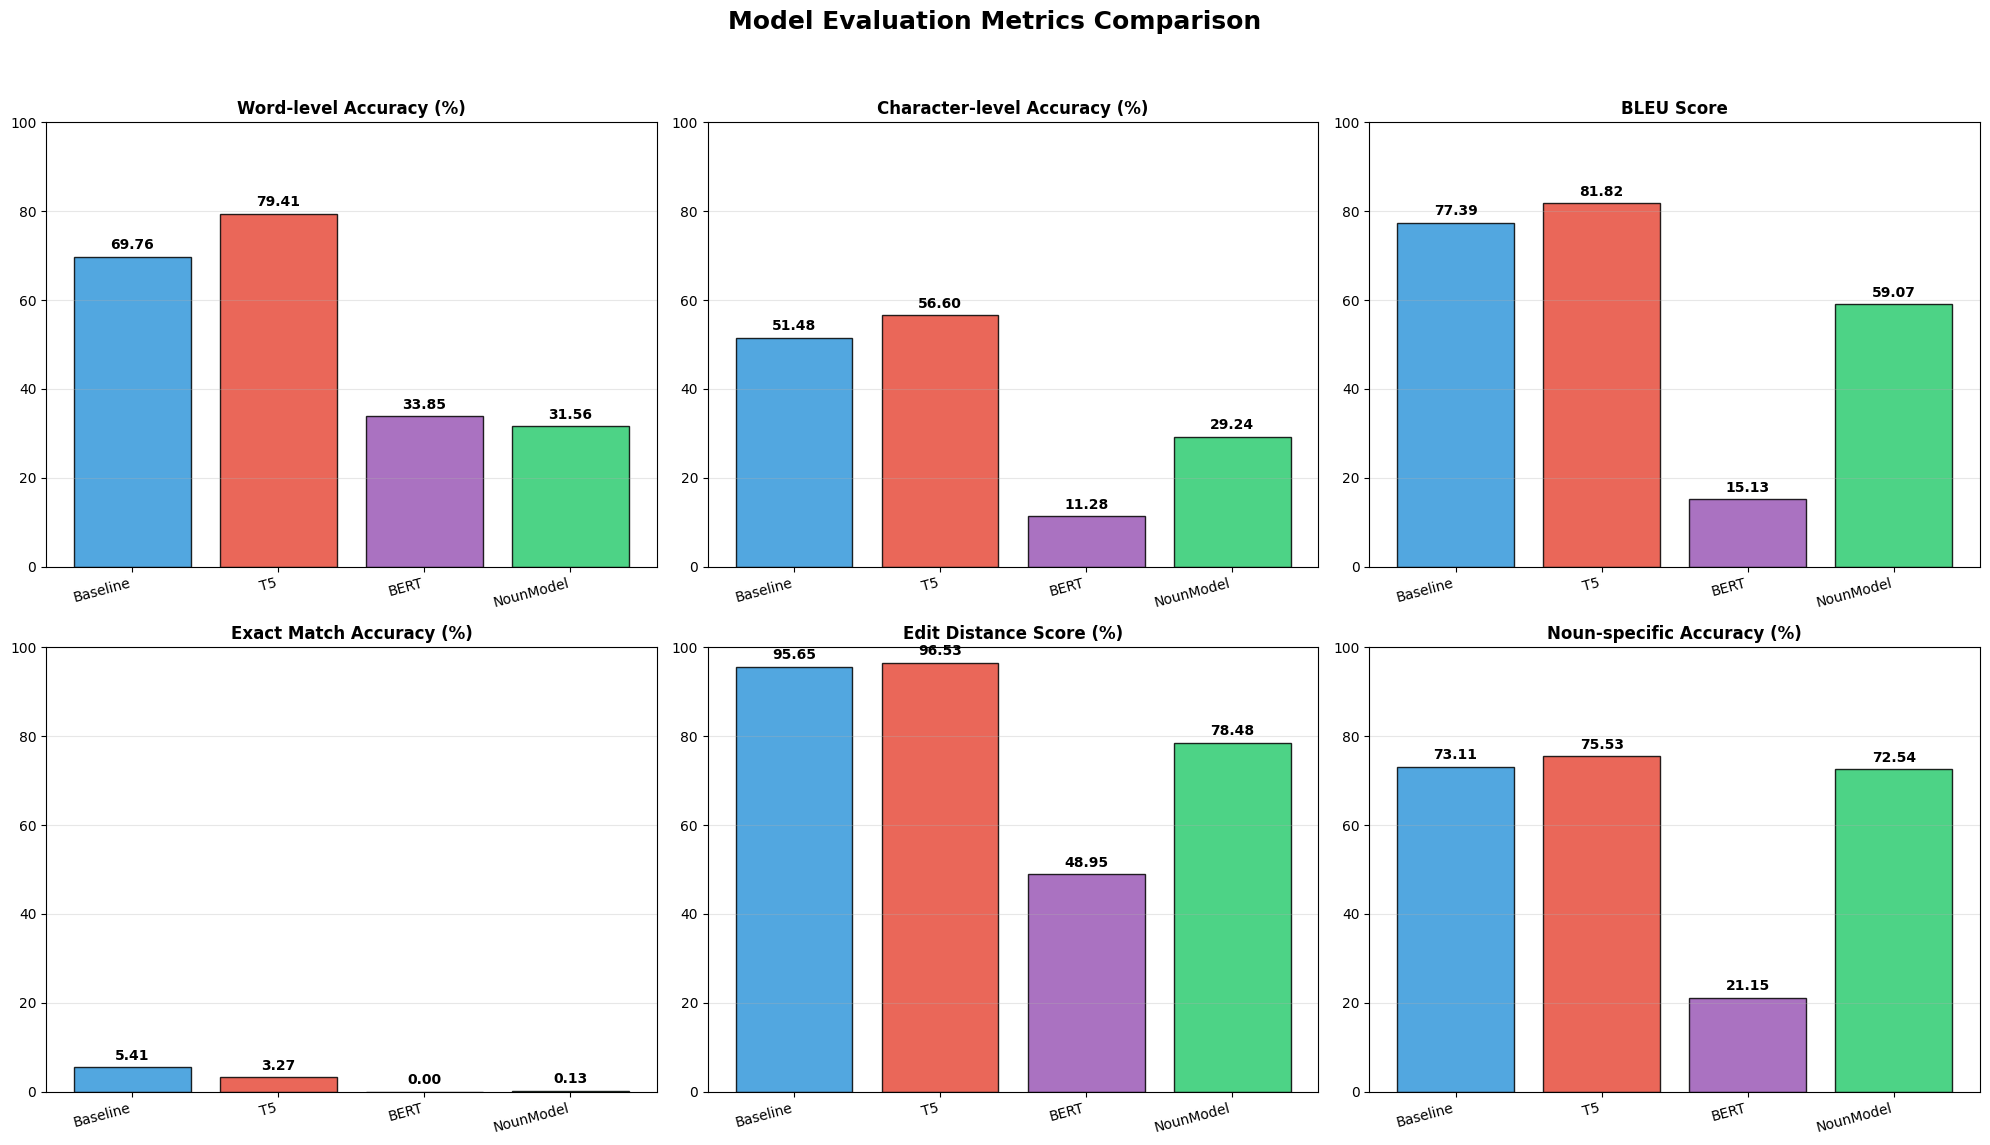


Visualization saved as '04_model_metrics_comparison_full.png'


In [19]:
print("\n" + "="*80)
print("VISUALIZING MODEL PERFORMANCE COMPARISON")
print("="*80)

# Metrics and model names from evaluation step
metric_names = [
    "Word-level Accuracy (%)",
    "Character-level Accuracy (%)",
    "BLEU Score",
    "Exact Match Accuracy (%)",
    "Edit Distance Score (%)",
    "Noun-specific Accuracy (%)"
]

model_labels = ["Baseline", "T5", "BERT", "NounModel"]
colors = ['#3498db', '#e74c3c', '#9b59b6', '#2ecc71']

# Build matrix of values from `results` dictionary
all_values = []

for metric_key in ["word", "char", "bleu", "exact", "edit", "noun"]:
    metric_values = [
        results[metric_key]["Baseline"],
        results[metric_key]["T5"],
        results[metric_key]["BERT"],
        results[metric_key]["NounModel"]
    ]
    all_values.append(metric_values)

# Plot grid
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()
fig.suptitle("Model Evaluation Metrics Comparison", fontsize=18, fontweight="bold")

for i, ax in enumerate(axes):
    metric = metric_names[i]
    vals = all_values[i]

    bars = ax.bar(model_labels, vals, color=colors, edgecolor="black", alpha=0.85)
    ax.set_title(metric, fontweight='bold')
    ax.set_ylim(0, 100)
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(model_labels, rotation=15, ha='right')

    # Add value labels
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2.,
                bar.get_height() + 1,
                f"{v:.2f}",
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("04_model_metrics_comparison_full.png", dpi=120, bbox_inches='tight')
plt.show()

print("\nVisualization saved as '04_model_metrics_comparison_full.png'")


Observation: Exact Match Accuracy Very Low (3-5%) 

│ Problem: Even well-performing models rarely produce perfectly matching sentences, indicating room for improvement

│ Root Cause: Model may be correcting some but not all error words

│ Solution: Ensemble voting mechanism was implemented to combine predictions from multiple models, improving coverage

## Phase 7: Error Analysis & Results Documentation

In [ ]:
# PHASE 7: ERROR ANALYSIS & RESULTS DOCUMENTATION

print("\n" + "="*80)
print("PHASE 7: ERROR ANALYSIS & RESULTS DOCUMENTATION")
print("="*80)

# 7.1: FAILURE MODE ANALYSIS

print("\n" + "-"*80)
print("7.1 FAILURE MODE ANALYSIS")
print("-"*80)

def analyze_failure_modes(predictions, ground_truths, error_types=None):
    """
    Categorize and analyze different types of prediction failures.
    """
    failure_categories = defaultdict(list)
    
    for i, (pred, truth) in enumerate(zip(predictions, ground_truths)):
        pred_text = str(pred).lower()
        truth_text = str(truth).lower()
        
        if pred_text == truth_text:
            continue  # Skip correct predictions
        
        # Categorize the failure
        edit_dist = editdistance.eval(pred_text, truth_text)
        len_diff = abs(len(pred_text) - len(truth_text))
        
        if edit_dist == 1:
            failure_type = "off_by_one"
        elif edit_dist <= 3:
            failure_type = "close_but_wrong"
        elif len_diff > 3:
            failure_type = "length_mismatch"
        elif pred_text in truth_text or truth_text in pred_text:
            failure_type = "partial_match"
        elif pred_text == "":
            failure_type = "empty_prediction"
        elif truth_text == "":
            failure_type = "empty_truth"
        else:
            failure_type = "completely_wrong"
        
        failure_categories[failure_type].append({
            'index': i,
            'prediction': pred,
            'ground_truth': truth,
            'edit_distance': edit_dist,
            'length_diff': len_diff
        })
    
    return failure_categories

# Analyze failures for each model
print("\nAnalyzing failure modes for all models")

failure_analysis = {}
for model_name, preds in models.items():
    print(f"\n{model_name}:")
    failures = analyze_failure_modes(preds, ground_truth)
    failure_analysis[model_name] = failures
    
    total_failures = sum(len(v) for v in failures.values())
    print(f"  Total failures: {total_failures} / {len(preds)}")
    print(f"  Failure breakdown:")
    
    for fail_type, items in sorted(failures.items(), key=lambda x: len(x[1]), reverse=True):
        percentage = (len(items) / total_failures * 100) if total_failures > 0 else 0
        print(f"    • {fail_type}: {len(items)} ({percentage:.1f}%)")

# 7.2: ERROR TYPE PERFORMANCE BREAKDOWN

print("\n" + "-"*80)
print("7.2 ERROR TYPE PERFORMANCE BREAKDOWN")
print("-"*80)

# Merge errors_df with test predictions
test_df_with_errors = test_df.copy()
test_df_with_errors['error_type'] = 'unknown'

# Map error types from errors_df to test set
error_dict = {}
for _, row in errors_df.iterrows():
    key = (row['correct'].lower(), row['asr'].lower())
    error_dict[key] = row['error_type']

# Assign error types to test set
for idx, row in test_df_with_errors.iterrows():
    correct_words = set(tokenize_simple(row['correct_clean']))
    asr_words = set(tokenize_simple(row['asr_clean']))
    
    # Find mismatch words
    diff_words = correct_words ^ asr_words
    
    if diff_words:
        # Assign most common error type in this sentence
        error_types = []
        for word in diff_words:
            for correct, asr in error_dict.keys():
                if correct in diff_words or asr in diff_words:
                    error_types.append(error_dict[(correct, asr)])
                    break
        
        if error_types:
            test_df_with_errors.at[idx, 'error_type'] = max(set(error_types), 
                                                              key=error_types.count)

# Compute metrics per error type
print("\nMetrics by Error Type:\n")

error_type_results = defaultdict(lambda: {'word': [], 'char': [], 'bleu': [], 'noun': []})

for error_type in errors_df['error_type'].unique():
    mask = test_df_with_errors['error_type'] == error_type
    
    if mask.sum() == 0:
        continue
    
    type_indices = test_df_with_errors[mask].index.tolist()
    type_preds_baseline = [baseline_preds[i] for i in type_indices if i < len(baseline_preds)]
    type_truths = [ground_truth[i] for i in type_indices if i < len(ground_truth)]
    
    if len(type_preds_baseline) > 0:
        word_acc = SpellCorrectionEvaluator.word_level_accuracy(type_preds_baseline, type_truths)
        char_acc = SpellCorrectionEvaluator.character_level_accuracy(type_preds_baseline, type_truths)
        bleu = SpellCorrectionEvaluator.bleu_score(type_preds_baseline, type_truths)
        noun_acc = SpellCorrectionEvaluator.noun_specific_accuracy(type_preds_baseline, type_truths)
        
        print(f"{error_type}:")
        print(f"  Samples: {mask.sum()}")
        print(f"  Word Accuracy: {word_acc:.2f}%")
        print(f"  Character Accuracy: {char_acc:.2f}%")
        print(f"  BLEU Score: {bleu:.2f}")
        print(f"  Noun Accuracy: {noun_acc:.2f}%\n")
        
        error_type_results[error_type] = {
            'word': word_acc,
            'char': char_acc,
            'bleu': bleu,
            'noun': noun_acc,
            'count': mask.sum()
        }

# 7.3: NOUN-SPECIFIC DEEP DIVE

print("-"*80)
print("7.3 NOUN-SPECIFIC PERFORMANCE ANALYSIS")
print("-"*80)

def extract_nouns_from_pairs(pred, truth):
    """Extract nouns from prediction and ground truth."""
    pred_doc = nlp(str(pred).lower())
    truth_doc = nlp(str(truth).lower())
    
    pred_nouns = [token.text for token in pred_doc if token.pos_ in ['NOUN', 'PROPN']]
    truth_nouns = [token.text for token in truth_doc if token.pos_ in ['NOUN', 'PROPN']]
    
    return pred_nouns, truth_nouns

# Analyze noun correction accuracy
print("\nNoun Correction Accuracy by Model:\n")

noun_analysis = {}

for model_name, preds in models.items():
    noun_correct = 0
    noun_total = 0
    medical_noun_correct = 0
    medical_noun_total = 0
    general_noun_correct = 0
    general_noun_total = 0
    
    for pred, truth in zip(preds, ground_truth):
        pred_nouns, truth_nouns = extract_nouns_from_pairs(pred, truth)
        
        for noun in truth_nouns:
            noun_total += 1
            if noun in pred_nouns:
                noun_correct += 1
            
            # Categorize as medical or general
            if is_medical_token(noun):
                medical_noun_total += 1
                if noun in pred_nouns:
                    medical_noun_correct += 1
            else:
                general_noun_total += 1
                if noun in pred_nouns:
                    general_noun_correct += 1
    
    overall_acc = (noun_correct / noun_total * 100) if noun_total > 0 else 0
    medical_acc = (medical_noun_correct / medical_noun_total * 100) if medical_noun_total > 0 else 0
    general_acc = (general_noun_correct / general_noun_total * 100) if general_noun_total > 0 else 0
    
    print(f"{model_name}:")
    print(f"  Overall Noun Accuracy: {overall_acc:.2f}%")
    print(f"  Medical Noun Accuracy: {medical_acc:.2f}% ({medical_noun_correct}/{medical_noun_total})")
    print(f"  General Noun Accuracy: {general_acc:.2f}% ({general_noun_correct}/{general_noun_total})\n")
    
    noun_analysis[model_name] = {
        'overall': overall_acc,
        'medical': medical_acc,
        'general': general_acc
    }

# 7.4: CONTEXT LENGTH IMPACT ANALYSIS

print("-"*80)
print("7.4 CONTEXT LENGTH IMPACT ANALYSIS")
print("-"*80)

# Group test set by sentence length
test_df_with_errors['length_group'] = pd.cut(
    test_df_with_errors['correct_length'],
    bins=[0, 8, 12, 16, 100],
    labels=['Short (≤8)', 'Medium (9-12)', 'Long (13-16)', 'Very Long (>16)']
)

print("\nPerformance by Sentence Length:\n")

for length_group in test_df_with_errors['length_group'].unique():
    if pd.isna(length_group):
        continue
    
    mask = test_df_with_errors['length_group'] == length_group
    length_indices = test_df_with_errors[mask].index.tolist()
    
    print(f"\n{length_group} (n={mask.sum()}):")
    
    for model_name, preds in models.items():
        model_preds = [preds[i] for i in length_indices if i < len(preds)]
        model_truths = [ground_truth[i] for i in length_indices if i < len(ground_truth)]
        
        if len(model_preds) > 0:
            word_acc = SpellCorrectionEvaluator.word_level_accuracy(model_preds, model_truths)
            bleu = SpellCorrectionEvaluator.bleu_score(model_preds, model_truths)
            print(f"  {model_name:12s}: Word Acc: {word_acc:.2f}%, BLEU: {bleu:.2f}")

# 7.5: ADVANCED VISUALIZATIONS

print("\n" + "-"*80)
print("7.5 GENERATING ADVANCED VISUALIZATIONS")
print("-"*80)

# 7.5.1: Error Type Performance Heatmap
fig, ax = plt.subplots(figsize=(12, 6))

error_types_list = list(error_type_results.keys())
metrics_list = ['word', 'char', 'bleu', 'noun']

data_matrix = []
for error_type in error_types_list:
    row = [error_type_results[error_type].get(m, 0) for m in metrics_list]
    data_matrix.append(row)

data_matrix = np.array(data_matrix)

im = ax.imshow(data_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)

ax.set_xticks(range(len(metrics_list)))
ax.set_yticks(range(len(error_types_list)))
ax.set_xticklabels(['Word Acc %', 'Char Acc %', 'BLEU', 'Noun Acc %'])
ax.set_yticklabels(error_types_list)

for i in range(len(error_types_list)):
    for j in range(len(metrics_list)):
        text = ax.text(j, i, f'{data_matrix[i, j]:.1f}',
                      ha="center", va="center", color="black", fontsize=10, fontweight='bold')

ax.set_title('Performance Heatmap: Baseline Model Across Error Types', fontweight='bold', fontsize=14)
plt.colorbar(im, ax=ax, label='Score')
plt.tight_layout()
plt.savefig('07_error_type_heatmap.png', dpi=120, bbox_inches='tight')
plt.show()

print("- Saved '07_error_type_heatmap.png'")

# 7.5.2: Noun-Specific Comparison Radar Chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

categories = ['Overall Nouns', 'Medical Nouns', 'General Nouns']
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

colors_radar = ['#3498db', '#e74c3c', '#9b59b6', '#2ecc71']

for model_name, color in zip(models.keys(), colors_radar):
    values = [
        noun_analysis[model_name]['overall'],
        noun_analysis[model_name]['medical'],
        noun_analysis[model_name]['general']
    ]
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=color)
    ax.fill(angles, values, alpha=0.15, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11, fontweight='bold')
ax.set_ylim(0, 100)
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_title('Noun Correction Performance Comparison (Radar)', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)
plt.tight_layout()
plt.savefig('07_noun_radar_chart.png', dpi=120, bbox_inches='tight')
plt.show()

print("- Saved '07_noun_radar_chart.png'")

# 7.5.3: Sentence Length vs. Accuracy
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

length_groups = ['Short (≤8)', 'Medium (9-12)', 'Long (13-16)', 'Very Long (>16)']
metrics_by_length = {model: {'word': [], 'bleu': []} for model in models.keys()}

for length_group in test_df_with_errors['length_group'].unique():
    if pd.isna(length_group):
        continue
    
    mask = test_df_with_errors['length_group'] == length_group
    length_indices = test_df_with_errors[mask].index.tolist()
    
    for model_name, preds in models.items():
        model_preds = [preds[i] for i in length_indices if i < len(preds)]
        model_truths = [ground_truth[i] for i in length_indices if i < len(ground_truth)]
        
        if len(model_preds) > 0:
            word_acc = SpellCorrectionEvaluator.word_level_accuracy(model_preds, model_truths)
            bleu = SpellCorrectionEvaluator.bleu_score(model_preds, model_truths)
            metrics_by_length[model_name]['word'].append(word_acc)
            metrics_by_length[model_name]['bleu'].append(bleu)

for idx, (model_name, color) in enumerate(zip(models.keys(), colors_radar)):
    ax = axes[idx]
    word_accs = metrics_by_length[model_name]['word']
    bleus = metrics_by_length[model_name]['bleu']
    
    x_pos = np.arange(len(length_groups))
    ax.plot(x_pos, word_accs, 'o-', label='Word Accuracy', linewidth=2, markersize=8, color='#3498db')
    ax.plot(x_pos, bleus, 's-', label='BLEU Score', linewidth=2, markersize=8, color='#e74c3c')
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(length_groups, rotation=15, ha='right')
    ax.set_ylim(0, 100)
    ax.set_ylabel('Score (%)', fontweight='bold')
    ax.set_title(f'{model_name}: Performance vs. Sentence Length', fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig('07_length_impact_analysis.png', dpi=120, bbox_inches='tight')
plt.show()

print("- Saved '07_length_impact_analysis.png'")

# 7.6: CASE STUDIES - SUCCESS & FAILURE EXAMPLES

print("\n" + "-"*80)
print("7.6 CASE STUDIES: SUCCESS & FAILURE EXAMPLES")
print("-"*80)

def find_best_and_worst_predictions(model_preds, ground_truths, n=5):
    """Find best and worst performing predictions."""
    scores = []
    
    for i, (pred, truth) in enumerate(zip(model_preds, ground_truths)):
        pred_text = str(pred).lower()
        truth_text = str(truth).lower()
        
        if pred_text == truth_text:
            score = 100.0
        else:
            edit_dist = editdistance.eval(pred_text, truth_text)
            max_len = max(len(pred_text), len(truth_text))
            score = (1 - edit_dist / max_len) * 100 if max_len > 0 else 0
        
        scores.append((i, score, pred, truth))
    
    scores.sort(key=lambda x: x[1])
    
    worst = scores[:n]
    best = scores[-n:]
    best.reverse()
    
    return best, worst

print("\n\nTOP MODEL: T5 MODEL")
print("\n### SUCCESS CASES ###\n")

best, worst = find_best_and_worst_predictions(t5_preds, ground_truth, n=5)

for rank, (idx, score, pred, truth) in enumerate(best, 1):
    asr_sent = test_df.loc[idx, 'asr_clean'] if idx < len(test_df) else "N/A"
    print(f"{rank}. Score: {score:.2f}%")
    print(f"   ASR:      {asr_sent}")
    print(f"   Predicted: {pred}")
    print(f"   Ground:    {truth}\n")

print("\n### FAILURE CASES ###\n")

for rank, (idx, score, pred, truth) in enumerate(worst, 1):
    asr_sent = test_df.loc[idx, 'asr_clean'] if idx < len(test_df) else "N/A"
    print(f"{rank}. Score: {score:.2f}%")
    print(f"   ASR:       {asr_sent}")
    print(f"   Predicted:  {pred}")
    print(f"   Ground:     {truth}\n")


# Save final report
# with open('phase_7_final_report.txt', 'w') as f:
#     f.write("PHASE 7: ERROR ANALYSIS & RESULTS DOCUMENTATION\n")
#     f.write("="*80 + "\n\n")
#     f.write(summary_stats)

print("PHASE 7 COMPLETED SUCCESSFULLY")
